#Title: Character Vectorization and Information Retrieval in Friends Script Data

## Author: Syed Farhan Haider

##Objective

The objective of this project is to create a vector representation of a document containing lines spoken by a character in the Friends script data. The goal is to optimize the vector representation such that each character vector is maximally distinguished from other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document.

##Code

In [1]:
!pip install nltk

In [2]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

import math

import nltk
from nltk import word_tokenize, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


###Data Loading and Preprocessing:
Loading training, validation, and test data from CSV files.


In [5]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data[:5]

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female


Creating a function (create_character_document_from_dataframe) to generate character documents from the dataframe.

In [4]:
from collections import defaultdict

def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them. Dialogue context includes lines spoken
    by other characters in the same scene (before and after).

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = defaultdict(list)

    # Grouping the dataframe by Episode and Scene
    grouped_df = df.groupby(['Episode', 'Scene'])

    for (_, _), group in grouped_df:
        for row in group.itertuples():
            name, line = row.Character_name, row.Line

            # Skipping empty lines
            if not line:
                continue

            # Appending the current line to the character's document list
            character_docs[name].append(f"{line} _EOL_")

    # Concatenating lines for each character and limit to max_line_count
    character_docs = {name: ' '.join(lines[:max_line_count]) for name, lines in character_docs.items()}

    return character_docs



Calculating and displaying the number of words for each character in the training set.

In [6]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

Num. Characters:  10 

Monica Geller Number of Words:  2937
Joey Tribbiani Number of Words:  3119
Chandler Bing Number of Words:  3963
Phoebe Buffay Number of Words:  3437
#ALL# Number of Words:  990
Ross Geller Number of Words:  3477
Rachel Green Number of Words:  3725
Other_None Number of Words:  2904
Other_Female Number of Words:  2733
Other_Male Number of Words:  3232
total words 30517


### Preprocessing:
Implementing a preprocessing function (pre_process) that handles lowercasing, tokenization, stop word removal, punctuation removal, stemming, number removal, and special character removal.
Testing the pre_process function on a sample text.

In [7]:
def pre_process(text):

    # Lowercasing
    text = text.lower()

    # Tokenization using NLTK's word_tokenize
    tokens = word_tokenize(text)

    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Removing Punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Stemming using Porter Stemmer
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Removing Numbers
    tokens = [token for token in tokens if not token.isdigit()]

    # Removing Special Characters
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens]

    return tokens

In [8]:
# Test the pre_process function
sample_text = "C'mon, I mean, I always knew looked familiar, but... Anyway, I just had to get o..."
processed_sample = pre_process(sample_text)
print("Original Text:", sample_text)
print("Processed Text:", processed_sample)

Original Text: C'mon, I mean, I always knew looked familiar, but... Anyway, I just had to get o...
Processed Text: ['cmon', 'mean', 'alway', 'knew', 'look', 'familiar', '', 'anyway', 'get', '']


In [9]:
# Create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

###Feature Extraction:
Implementing a function (to_feature_vector_dictionary) to convert pre-processed tokens and extra features to a feature vector dictionary.
Utilizing TF-IDF transformation for feature extraction.

In [10]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import ngrams, pos_tag
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Initialize the sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()

def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Modifications done ::
    > Counts of pre-processed tokens
    > Sentiment score
    > Ngram counts

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to the feature vector dict
    """
    counts = Counter(character_doc)  # for now, a simple count
    counts = dict(counts)

    # Sentiment score using VADER
    sentiment_scores = sentiment_analyzer.polarity_scores(' '.join(character_doc))

    # Add the sentiment score to the feature vector dict
    counts['sentiment_score'] = sentiment_scores['compound']

    # N-gram counts
    n_grams = list(ngrams(character_doc, 4)) #4
    n_gram_counts = Counter(n_grams)
    n_gram_counts = {f'ngram_{n_gram}': count for n_gram, count in n_gram_counts.items()}
    counts.update(n_gram_counts)

    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1

    return counts

In [11]:
def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Modifications done ::
    > Using TF-IDF transformation

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for _, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for _, doc in corpus])

    # Use TF-IDF transformation
    tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix_tfidf = tfidf_transformer.transform(doc_feature_matrix)

    return doc_feature_matrix_tfidf

Transforming the training matrix

In [12]:
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
training_feature_matrix

<10x21327 sparse matrix of type '<class 'numpy.float64'>'
	with 24913 stored elements in Compressed Sparse Row format>

Calculating and displaying the number of words for each character in the validation set.

In [13]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

Num. Characters:  10 

Other_None Num of Words:  397
Rachel Green Num of Words:  276
Other_Male Num of Words:  410
Ross Geller Num of Words:  242
#ALL# Num of Words:  77
Phoebe Buffay Num of Words:  359
Chandler Bing Num of Words:  299
Monica Geller Num of Words:  275
Joey Tribbiani Num of Words:  251
Other_Female Num of Words:  425
total words 3011


Creating list of pairs of (character name, pre-processed character) for validation set

In [14]:
# Creating list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

In [15]:
# Just transforming the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)
val_feature_matrix

<10x21327 sparse matrix of type '<class 'numpy.float64'>'
	with 930 stored elements in Compressed Sparse Row format>

### Information Retrieval Evaluation:
Creating a function (compute_IR_evaluation_scores) to compute an IR-based evaluation on training and test data.
Evaluating mean rank, mean cosine similarity, accuracy, and generating a dataframe with similarity measures.

In [16]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [17]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [18]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    fig.tight_layout()
    plt.show()

In [19]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.2
mean cosine similarity 0.7407459164746795
7 correct out of 10 / accuracy: 0.7


###Hyperparameter Tuning:
Defining parameter grids for preprocessing and feature extraction.
Iterating over parameter combinations to find the optimal set of parameters that minimizes the mean rank.

In [20]:
# Creating new preprocess function that will run on all permutation combination of parameters

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def pre_process(text, remove_punctuation=True, stemming=True, remove_numbers=True, remove_special_characters=True):

    # Lowercasing
    text = text.lower()

    # Tokenization using NLTK's word_tokenize
    tokens = word_tokenize(text)

    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Removing Punctuation
    if remove_punctuation:
        tokens = [token for token in tokens if token not in string.punctuation]

    # Stemming using Porter Stemmer
    if stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    # Removing Numbers
    if remove_numbers:
        tokens = [token for token in tokens if not token.isdigit()]

    # Removing Special Characters
    if remove_special_characters:
        tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens]

    return tokens

In [25]:
# Creating new to_feature_vector_dictionary function that will run on all permutation combination of parameters

def to_feature_vector_dictionary(character_doc, extra_features,sentiment_score, Ngram, n):

    counts = Counter(character_doc)  # for now, a simple count
    counts = dict(counts)

    if sentiment_score:
      # Sentiment score using VADER
      sentiment_scores = sentiment_analyzer.polarity_scores(' '.join(character_doc))

      # Add the sentiment score to the feature vector dict
      counts['sentiment_score'] = sentiment_scores['compound']

    if Ngram:
      # N-gram counts
      n_grams = list(ngrams(character_doc, n)) #4
      n_gram_counts = Counter(n_grams)
      n_gram_counts = {f'ngram_{n_gram}': count for n_gram, count in n_gram_counts.items()}
      counts.update(n_gram_counts)

    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1

    return counts

In [26]:
# Modifying the function for multiple runs on combination of parameters

def create_document_matrix_from_corpus(corpus, fitting=False, sentiment_score=True, Ngram=True, n=4):

    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, [], sentiment_score, Ngram, n) for _, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, [],sentiment_score, Ngram, n) for _, doc in corpus])

    # Use TF-IDF transformation
    tfidf_transformer.fit(doc_feature_matrix)
    doc_feature_matrix_tfidf = tfidf_transformer.transform(doc_feature_matrix)

    return doc_feature_matrix_tfidf

In [27]:
def get_similarity_matrix(similarity_df):
    """
    Given a DataFrame with columns 'doc1', 'doc2', and 'similarity',
    returns a similarity matrix as a DataFrame.

    Parameters:
    > similarity_df: DataFrame with columns 'doc1', 'doc2', and 'similarity'

    Returns:
    > similarity_matrix: DataFrame representing the similarity matrix
    """
    # Create a pivot table to reshape the DataFrame into a matrix
    similarity_matrix = similarity_df.pivot(index='doc1', columns='doc2', values='similarity')

    # Fill NaN values with 0 (for cases where doc1 and doc2 are the same)
    similarity_matrix = similarity_matrix.fillna(0)

    return similarity_matrix

In [29]:
from sklearn.model_selection import ParameterGrid
import os
import sys

# Defining the parameter grid
param_grid_preprocess = {
    'remove_punctuation': [True, False],
    'stemming': [True, False],
    'remove_numbers': [True, False],
    'remove_special_characters': [True, False]
}
param_grid_feature = {
    'Ngram': [True, False],
    'n': [3,4,5],
    'sentiment_score': [True, False]
}

# Generating all possible combinations of parameters
param_combinations = list(ParameterGrid(param_grid_preprocess))
param_feature_combinations = list(ParameterGrid(param_grid_feature))

rank = 5
global best_params_preprocess # Global parameter variables to store best parameters after grid search
global best_params_feature

# Iterating over parameter combinations
for params in param_combinations:
  for param_feature in param_feature_combinations:

    # Only use the first 300 lines of each character
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
    total_words = 0
    for name in train_character_docs.keys():
      total_words += len(train_character_docs[name].split())

   # Create list of pairs of (character name, pre-processed character)
    training_corpus = [(name, pre_process(doc, **params)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    # Apply pre-processing with the current parameter combination
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, **param_feature)


    # get the validation data- only 30 lines used for each character
    val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)

    total_words = 0
    for name in val_character_docs.keys():
        total_words += len(val_character_docs[name].split())

    # create list of pairs of (character name, pre-processed character)
    val_corpus = [(name, pre_process(doc, **params)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]

    # Just transform the val_feature_matrix, don't fit
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, **param_feature)

    # To ignore the output from compute_IR_evaluation_scores()
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

    result = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    # Print or store the results for each parameter combination
    sys.stdout = original_stdout
    mean_rank, _, _, _ = result


    if(rank > mean_rank):
      best_params_preprocess = params
      best_params_feature = param_feature
      rank = mean_rank
      print(rank)

print(best_params_preprocess, '\n', best_params_feature)
print(rank)

2.3
2.2
2.1
{'remove_numbers': True, 'remove_punctuation': True, 'remove_special_characters': True, 'stemming': True} 
 {'Ngram': False, 'n': 3, 'sentiment_score': True}
2.1


###Visualization:
Plotting a heatmap to visualize the similarity matrix between documents as vectors.


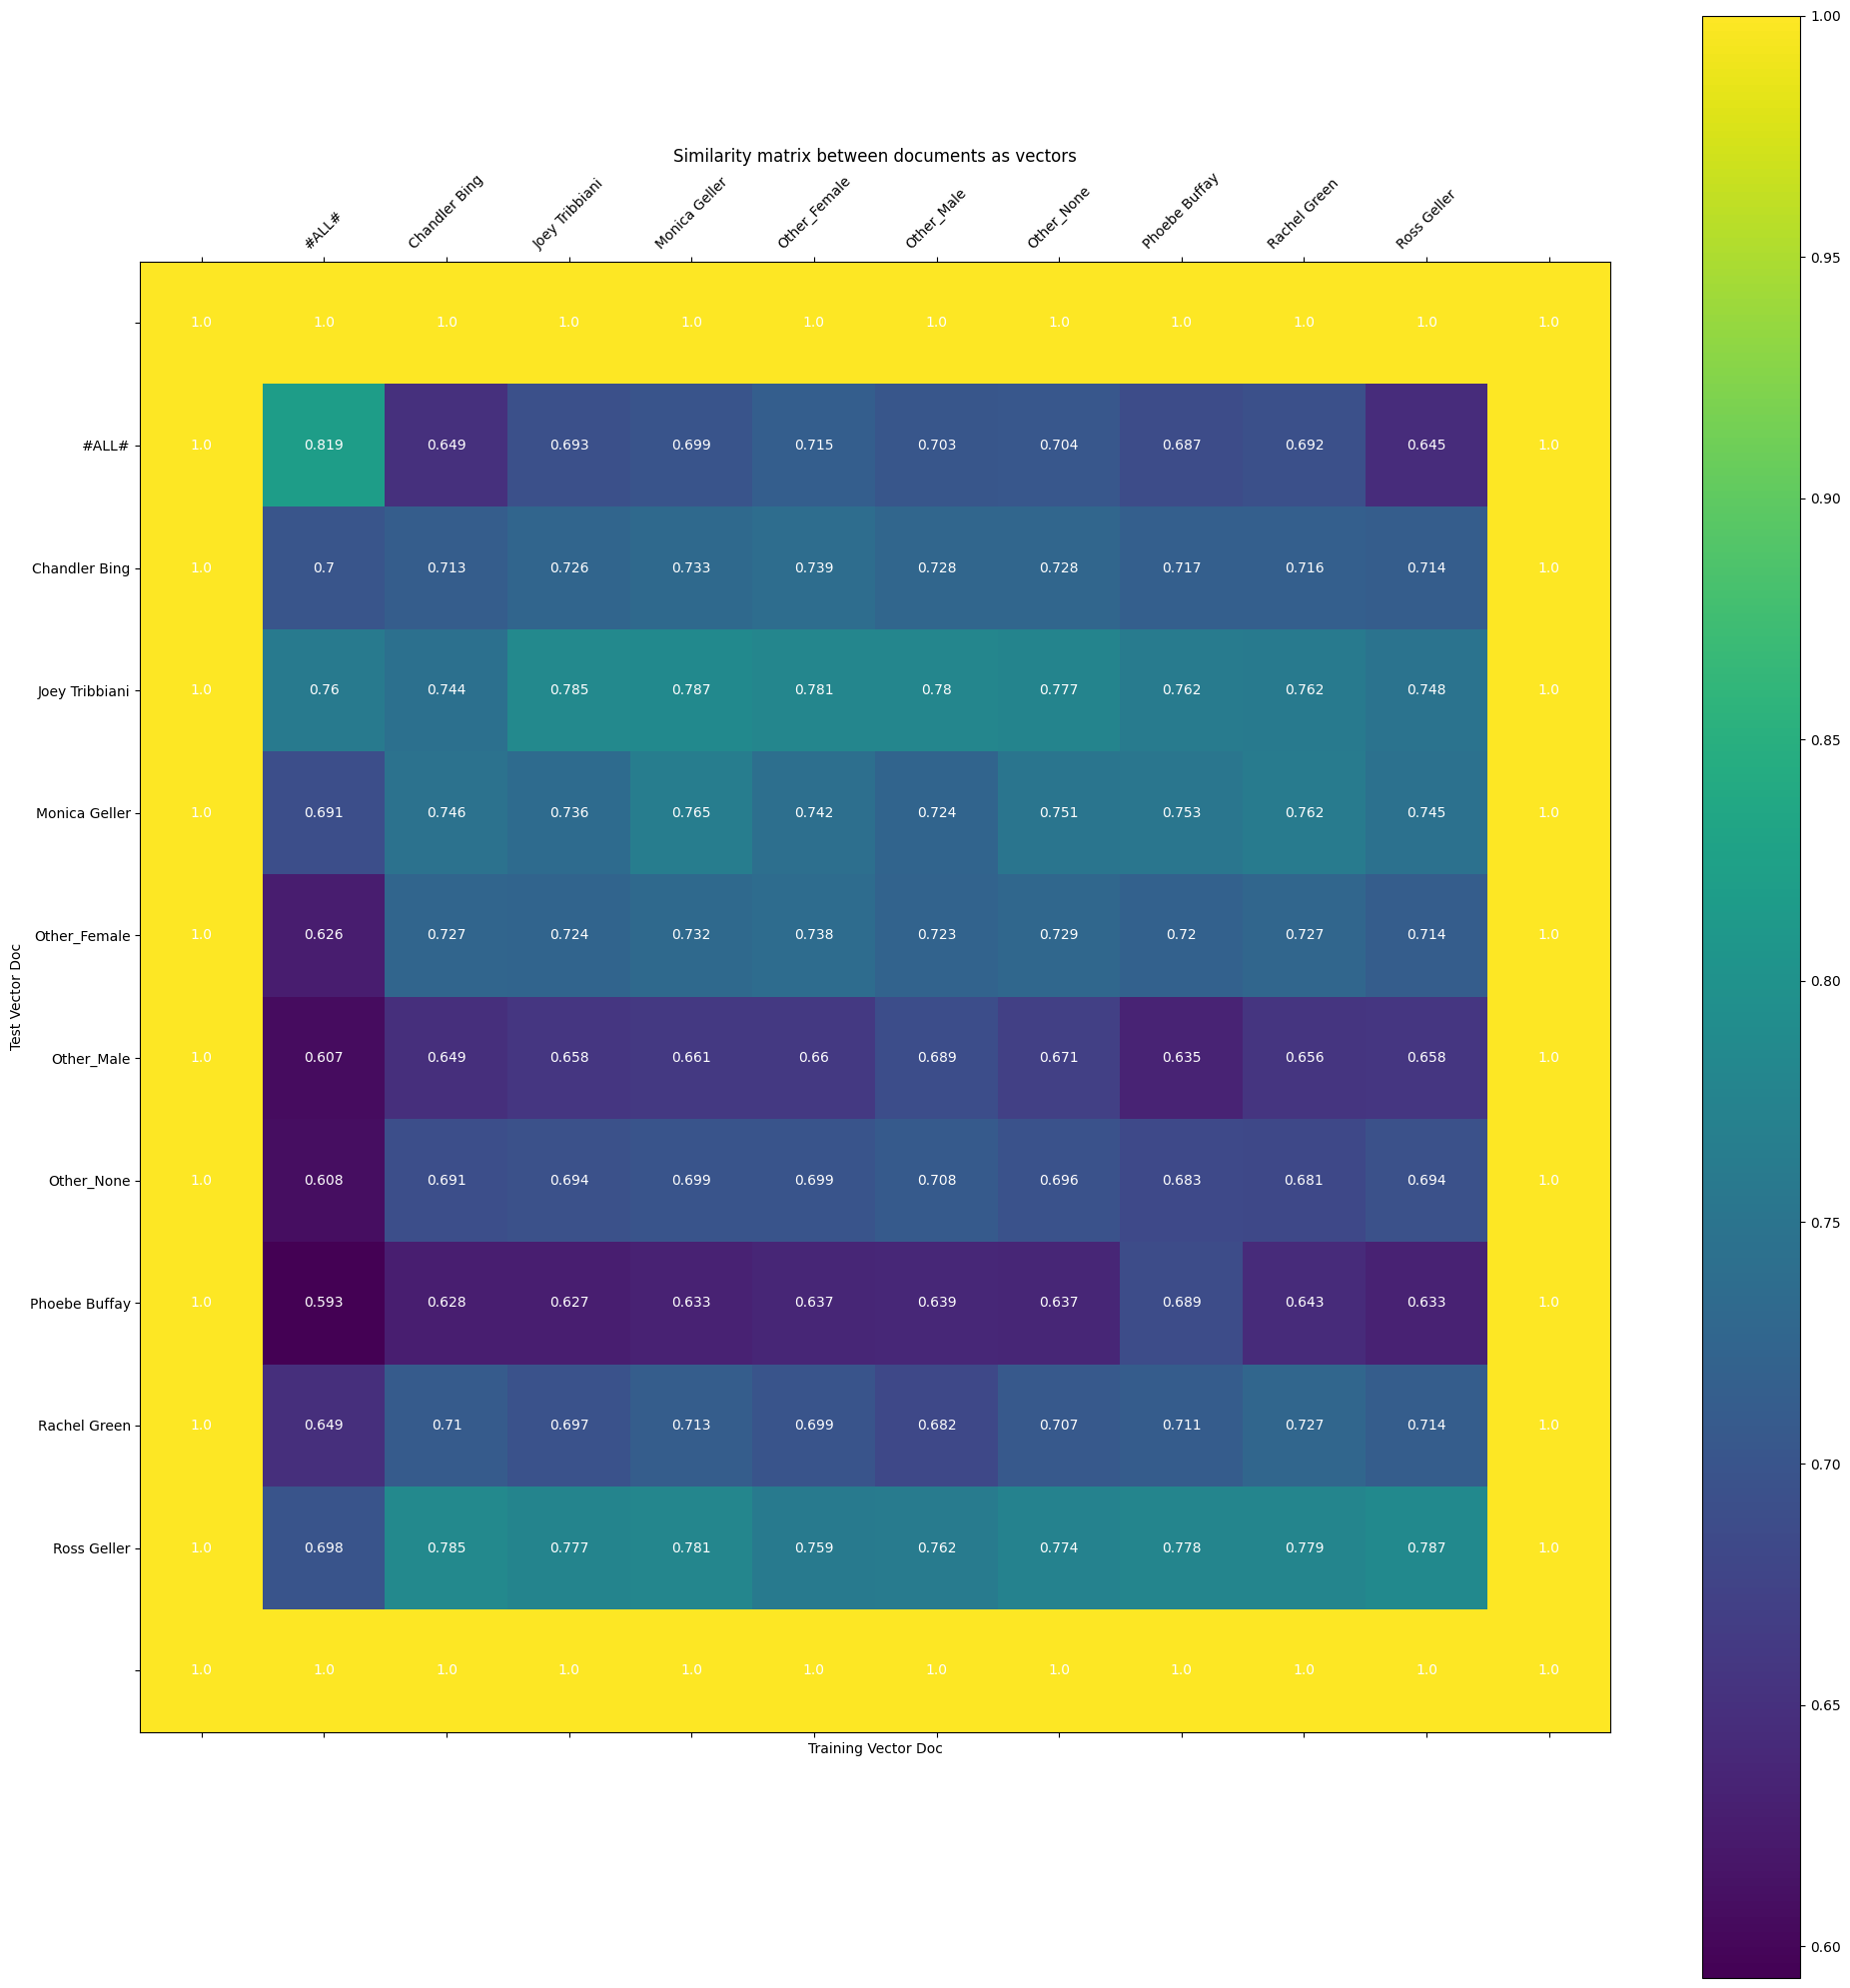

In [30]:
plot_heat_map_similarity(df)

## Testing

In [31]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)
print('-------------------------------')

training_corpus = [(name, pre_process(doc, **best_params_preprocess)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, **best_params_feature)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)
print('-------------------------------')

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc, **best_params_preprocess)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, **best_params_feature)
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

Num. Characters:  10 

Monica Geller Number of Words:  2937
Joey Tribbiani Number of Words:  3119
Chandler Bing Number of Words:  3963
Phoebe Buffay Number of Words:  3437
#ALL# Number of Words:  990
Ross Geller Number of Words:  3477
Rachel Green Number of Words:  3725
Other_None Number of Words:  2904
Other_Female Number of Words:  2733
Other_Male Number of Words:  3232
total words 30517
-------------------------------
Num. Characters:  10 

Ross Geller Number of Words:  458
Joey Tribbiani Number of Words:  336
Chandler Bing Number of Words:  306
Other_Female Number of Words:  225
Other_None Number of Words:  256
#ALL# Number of Words:  44
Monica Geller Number of Words:  277
Rachel Green Number of Words:  302
Phoebe Buffay Number of Words:  292
Other_Male Number of Words:  347
total words 2843
-------------------------------
mean rank 2.1
mean cosine similarity 0.7947194663306891
7 correct out of 10 / accuracy: 0.7


##Results:
The project provides a comprehensive analysis of the preprocessing and feature extraction parameters' impact on the mean rank in an IR evaluation.
It identifies the optimal set of parameters for maximizing the distinction between character vectors.

> The final model achieved a **mean rank of 2.1** and an **accuracy of 70%** in distinguishing characters.

##Recommendations:
The findings suggest that the optimized vector representation and the identified parameters can significantly improve character-based analyses in script data. Future research could explore advanced NLP techniques and deep learning models to further refine character distinction and uncover more complex linguistic patterns in TV show scripts.

##Conclusion:
The project effectively optimized vector representations for character documents in the "Friends" script data. By fine-tuning preprocessing and feature extraction parameters, we significantly enhanced the distinction between character vectors. The analysis demonstrated the utility of sentiment analysis, n-gram counts, and TF-IDF transformation in creating distinguishable character profiles based on their dialogue. The visualizations, particularly the heatmap, provided insightful views into the relationships and similarities among characters.